# Stanford Stats 191

## Introduction

This is a re-creation of the Stanford Stats 191 course (see https://web.stanford.edu/class/stats191/), using Python eco-system tools, instead of R. This is lecture "Analysis of variance:", Part 1


## Initial Notebook Setup

```watermark ``` documents the current Python and package environment, ```black``` is my preferred Python formatter

In [107]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [108]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [109]:
%matplotlib inline

In [110]:
import pandas as pd
import numpy as np
import seaborn as sn

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.formula.api import rlm
import statsmodels.api as sm

from patsy import dmatrices

from patsy.contrasts import Treatment
from patsy.contrasts import Sum
from patsy.contrasts import Diff


from statsmodels.sandbox.regression.predstd import (
    wls_prediction_std,
)

import warnings

----
## Load Datset

In this post, we examine a range of datasets, where the explanatory variables are _all_ categorical.

We load the first example which records the time to recover after medical treatment, and where patients fitness levels have been recorded

In [111]:
data = pd.read_csv('../data/rehab.csv')

Get the pandas descriptive quantative summary

In [112]:
data.describe()

,Fitness,Time
count,24.000000,24.000000
mean,1.916667,32.000000
std,0.775532,6.877816
min,1.000000,20.000000
25%,1.000000,28.750000
50%,2.000000,31.000000
75%,2.250000,38.250000
max,3.000000,43.000000


### Visualize Dataset

We use ```pandas``` and ```seaborn``` to draw boxplots.  It does appear that increased Fitness will reduce the recovery Time

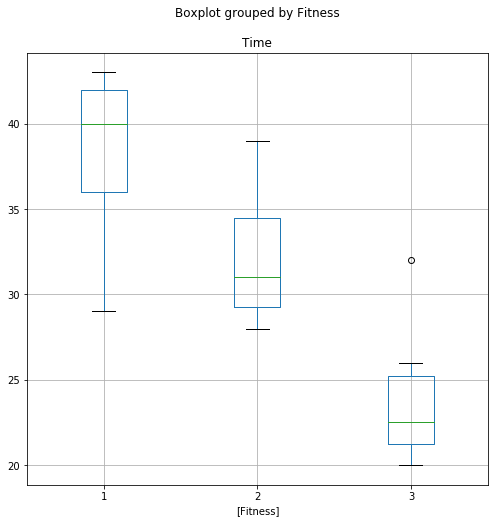

In [113]:
fig, ax = plt.subplots(figsize=(8, 8))
data.boxplot(by='Fitness', ax=ax)

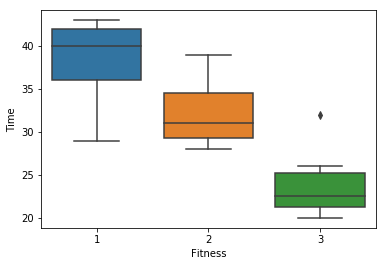

In [114]:
sn.boxplot(x='Fitness', y='Time', data=data)


----
### Fit Model by OLS

We first declare the Fitness level to be a categorical (not numeric) variable, and then perform an OLS best for of a model where Time depend on Fitness.  As we expect, the coefficients for Fitness levels greater than 1 are negative, predicting decreased recovery Time, the more Fitness the patient has

In [115]:
data['Fitness'] = data['Fitness'].astype('category')

data.dtypes

Fitness    category
Time          int64
dtype: object

In [116]:
res1 = ols('Time ~ Fitness ', data=data).fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Time   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     16.96
Date:                Sun, 29 Mar 2020   Prob (F-statistic):           4.13e-05
Time:                        14:53:25   Log-Likelihood:                -68.286
No. Observations:                  24   AIC:                             142.6
Df Residuals:                      21   BIC:                             146.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       38.0000      1.574     24.149      0.000      34.728      41.272
Fitness[T.2]    -6.0000      2.111     -2.842      0.010     -10.390      -1.610
Fitness[T.3]   -14.0000      2.404     -5.824      0.000     -18.999      -9.001
==============================================================================
Omnibus:                        0.163   Durbin-Watson:                   2.209
Prob(Omnibus):                  0.922   Jarque-Bera (JB):                0.211
Skew:                          -0.163   Prob(JB):                        0.900
Kurtosis:                       2.675   Cond. No.                         3.80
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Under the best-fit model, the prediction for Time for a given Fitness will equal the mean for all actual values of Time with theat level of Fitness.

First, we get the means for all levels of Fitness

In [117]:
tr_means = data.groupby('Fitness').mean()
tr_means

,Time
Fitness,
1,38
2,32
3,24


In [118]:
tr_counts = data.groupby('Fitness').count()
tr_counts

,Time
Fitness,
1,8
2,10
3,6


And now we see the predicted values for all levels of Fitness

In [119]:
res1.predict()

array([38., 38., 38., 38., 38., 38., 38., 38., 32., 32., 32., 32., 32.,
       32., 32., 32., 32., 32., 24., 24., 24., 24., 24., 24.])

In [120]:
res1.predict({'Fitness': [1, 2, 3]})

0    38.0
1    32.0
2    24.0
dtype: float64

### Explicit computation of F Statistic

In [121]:
#
# get sum of squares of the residual error (predicted - actual)

sse = sum(
    (data['Time'] - res1.predict())
    * (data['Time'] - res1.predict())
)

mean_sse = sse / (24 - 2 - 1)
mean_sse

19.809523809523807

In [122]:
#
# get sum of squares of the residual around the mean

ssr = sum(
    (data['Time'].mean() - res1.predict())
    * (data['Time'].mean() - res1.predict())
)
mean_ssr = ssr / (3 - 1)
mean_ssr

336.0

In [123]:
#
# get sum of squares of the actual around the mean

sum(
    (data['Time'] - data['Time'].mean())
    * (data['Time'] - data['Time'].mean())
)

1088.0

In [124]:
F = mean_ssr / mean_sse
F

16.961538461538463

### Using Statsmodels ANOVA

In [125]:
sm.stats.anova_lm(res1)

,df,sum_sq,mean_sq,F,PR(>F)
Fitness,2.0,672.0,336.000000,16.961538,0.000041
Residual,21.0,416.0,19.809524,NaN,NaN


Explicit computation of seeing an F value this big, with these degrees of freedom

In [126]:
df_tr = 2
df_res = 21

1 - stats.f.cdf(F, df_tr, df_res)

4.129301274979902e-05

We can aso use the Survival Function, which is more accurate for small values (here, very close)

In [127]:
stats.f.sf(F, df_tr, df_res)

4.1293012749812944e-05

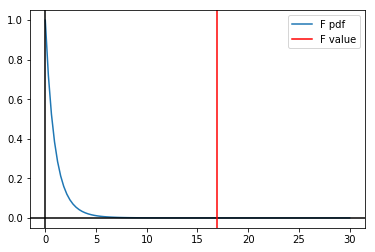

In [128]:
x = np.linspace(0.001, 30, 100)
y = stats.f.pdf(x, df_tr, df_res)
plt.plot(x, y, label='F pdf')
plt.axhline(0, color='k')
plt.axvline(F, color='r', label='F value')
plt.axvline(0, color='k')
plt.legend(loc='best')

-------------
## Data Set 2

The second dataset again has two categorical variables (Weight, and Duration).  The number of Days under care is converted to a ```log``` value, maybe because we are interested in the ratio of recovery time, not the actual numbers


|Variable|	Description|
|--|--|
Days|	Duration of hospital stay
Weight|	How much weight is gained?
Duration|	How long under treatment for kidney problems? (two levels)

### Read and Explore Dataset

In [129]:
data = pd.read_fwf('../data/kidneytable.txt')

In [130]:
len(data)

60

In [131]:
data.head()

,Days,Duration,Weight,ID
0,0.0,1,1,1
1,2.0,1,1,2
2,1.0,1,1,3
3,3.0,1,1,4
4,0.0,1,1,5


In [132]:
data['Duration'].unique()

array([1, 2], dtype=int64)

In [133]:
data['Weight'].unique()

array([1, 2, 3], dtype=int64)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022A7E674AC8>]],
      dtype=object)

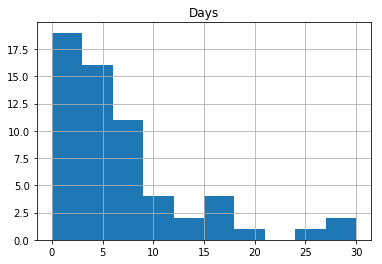

In [134]:
data.hist(column='Days')

### Set  datatype for analysis

We convert Days to LogDays, compute a Group variable (ie which group an observation is in, given its Weight and Duration values), and declare Weight and Duration to be categorical variables

In [135]:
data['Group'] = (data['Duration'] - 1) * 3 + data['Weight']

data['Duration'] = data['Duration'].astype('category')
data['Weight'] = data['Weight'].astype('category')
data['LogDays'] = np.log(data['Days'] + 1)

In [136]:
data.head()

,Days,Duration,Weight,ID,Group,LogDays
0,0.0,1,1,1,1,0.000000
1,2.0,1,1,2,1,1.098612
2,1.0,1,1,3,1,0.693147
3,3.0,1,1,4,1,1.386294
4,0.0,1,1,5,1,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022A7E6395F8>]],
      dtype=object)

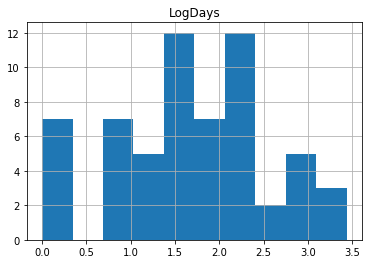

In [137]:
data.hist(column='LogDays')

### Interaction Plot

We can assess if there are inter-variable interactions by the interaction plot.  If the lines are not parallel, then interactions may be present

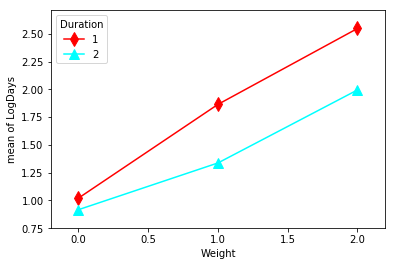

In [138]:
_ = sm.graphics.interaction_plot(
    data['Weight'],
    data['Duration'],
    data['LogDays'],
    markers=['d', '^'],
    markersize=10,
)

-----
### Build a Model

The model we build is different to previous models (see equation below). Here, alpha_i is the coefficient of the i_th level of the first categorical variable (Duration), beta_j is the coefficient of the j_th level of the second categorical variable, and alphabeta_ij is the coefficient of the  i_th level of the first categorical variable (Duration) being present with the j_th level of the second categorical variable

The Null Hypothesis is that there are no main effects (alpha_i = 0 for all i, beta_j = 0 for all j, and alphabeta_ij = 0 for all i,j)

The default way ```statsmodels``` OLS builds the matrix of observations for categorical variables is to create new variable (one for each level of the category, except the base level). These new variables are 1 if the observation has that value of the category, and zero otherwise.


In this example, we want the sum of the coefficients to be zero for both categorical variables.  We declare this in the ```ols``` call, by specifying we want the new variable to be coded so the sum is zero.  I must confess I don't know if the ```C``` stands for Contrast, Coding or Categorical (I think the latter)

$$Y_{ijk} = \mu + \alpha_i + \beta_j + (\alpha \beta)_{ij} +         
  \varepsilon_{ijk} , \qquad \varepsilon_{ijk} \sim N(0, \sigma^2)$$

In [139]:
res2 = ols(
    'LogDays ~ C(Duration, Sum) * C(Weight, Sum)', data=data
).fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                LogDays   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     7.431
Date:                Sun, 29 Mar 2020   Prob (F-statistic):           2.30e-05
Time:                        14:54:58   Log-Likelihood:                -63.314
No. Observations:                  60   AIC:                             138.6
Df Residuals:                      54   BIC:                             151.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     1.6140      0.095     17.063      0.000       1.424       1.804
C(Duration, Sum)[S.1]                         0.1975      0.095      2.088      0.042       0.008       0.387
C(Weight, Sum)[S.1]                          -0.6450      0.134     -4.821      0.000      -0.913      -0.377
C(Weight, Sum)[S.2]                          -0.0126      0.134     -0.095      0.925      -0.281       0.256
C(Duration, Sum)[S.1]:C(Weight, Sum)[S.1]    -0.1454      0.134     -1.087      0.282      -0.414       0.123
C(Duration, Sum)[S.1]:C(Weight, Sum)[S.2]     0.0662      0.134      0.495      0.623      -0.202       0.334
==============================================================================
Omnibus:                        7.659   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                2.856
Skew:                          -0.168   Prob(JB):                        0.240
Kurtosis:                       1.985   Cond. No.                         1.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It appears from the above that the interaction effects are not significant.  The effect of Duration is significant (at the 5% level). The first coded Weight variable has a significant effect, but not the other coded Weight variable.

----
### Get Design Matrix

The Design Matrix is the numerical, matrix representation of our model.  Note that we no longer have 0,1 in our new variables, but negative values as well

In [140]:
y, X = dmatrices(
    'LogDays ~ C(Duration, Sum) * C(Weight, Sum)',
    data=data,
    return_type='dataframe',
)

X.head()

,Intercept,"C(Duration, Sum)[S.1]","C(Weight, Sum)[S.1]","C(Weight, Sum)[S.2]","C(Duration, Sum)[S.1]:C(Weight, Sum)[S.1]","C(Duration, Sum)[S.1]:C(Weight, Sum)[S.2]"
0,1.0,1.0,1.0,0.0,1.0,0.0
1,1.0,1.0,1.0,0.0,1.0,0.0
2,1.0,1.0,1.0,0.0,1.0,0.0
3,1.0,1.0,1.0,0.0,1.0,0.0
4,1.0,1.0,1.0,0.0,1.0,0.0


In [141]:
X.tail()

,Intercept,"C(Duration, Sum)[S.1]","C(Weight, Sum)[S.1]","C(Weight, Sum)[S.2]","C(Duration, Sum)[S.1]:C(Weight, Sum)[S.1]","C(Duration, Sum)[S.1]:C(Weight, Sum)[S.2]"
55,1.0,-1.0,-1.0,-1.0,1.0,1.0
56,1.0,-1.0,-1.0,-1.0,1.0,1.0
57,1.0,-1.0,-1.0,-1.0,1.0,1.0
58,1.0,-1.0,-1.0,-1.0,1.0,1.0
59,1.0,-1.0,-1.0,-1.0,1.0,1.0


### Get Coding Rules

We can get the new coding rules by calling the ```Sum``` object.  For example, Weight has three level, so we have two new variables ```C(Weight, Sum)[S.1]```  and ```C(Weight, Sum)[S.2]```.  The value of each of these new variables has (as Weight ranges over it three level), is given by the columns of the ```Weight Coding``` matrix show below.  Similarly, the values of the ```C(Duration, Sum)[S.1]``` variable (for the two levels of Duration) is in the ```Duration Coding``` matrix below


All this matters, because if we want to an explicit calculation of a predicted value given observed Duration and Weight, we have to calculate the value of these newly created variables.  The ```coded_observation``` function below computes the vector of new variable values, to use with the coefficients returned by the ```ols``` call, to get predicted value.

In [142]:
w_levels = [1, 2, 3]
w_contrast = Sum().code_without_intercept(w_levels)
print('Weight Coding\n', w_contrast.matrix)

d_levels = [1, 2]
d_contrast = Sum().code_without_intercept(d_levels)
print('Duration Coding\n', d_contrast.matrix)

Weight Coding
 [[ 1.  0.]
 [ 0.  1.]
 [-1. -1.]]
Duration Coding
 [[ 1.]
 [-1.]]


In [143]:
d1_codes = {1: 1, 2: -1}
w1_codes = {1: 1, 2: 0, 3: -1}
w2_codes = {1: 0, 2: 1, 3: -1}

In [144]:
def coded_observation(D, W, d1_codes, w1_codes, w2_codes):

    vec = [
        1,  # constant
        d1_codes[D],  # D1
        w1_codes[W],  # W1
        w2_codes[W],  # W2
        d1_codes[D] * w1_codes[W],  # D1:W1
        d1_codes[D] * w2_codes[W],  # D1:W2
    ]
    return vec


# end coded_observation

Compare the explicitly calculated prediction with the  ```RegressionResults.predict()``` method 

In [145]:
for D in [1, 2]:
    for W in [1, 2, 3]:
        dd = {'Duration': D, 'Weight': W}
        pred1 = res2.predict(dd)[0]

        vec1 = coded_observation(
            D, W, d1_codes, w1_codes, w2_codes
        )
        pred2 = sum(vec1 * res2.params.values)

        print(
            f'Explicit Prediction vs Method Call: {pred2:10.5f} vs {pred1:10.5f}'
        )

    # end for
# end for

Explicit Prediction vs Method Call:    1.02116 vs    1.02116
Explicit Prediction vs Method Call:    1.86502 vs    1.86502
Explicit Prediction vs Method Call:    2.54827 vs    2.54827
Explicit Prediction vs Method Call:    0.91695 vs    0.91695
Explicit Prediction vs Method Call:    1.33772 vs    1.33772
Explicit Prediction vs Method Call:    1.99495 vs    1.99495


-------
### Visualize Model

Plot the raw data nd the modelpredictions on one graph

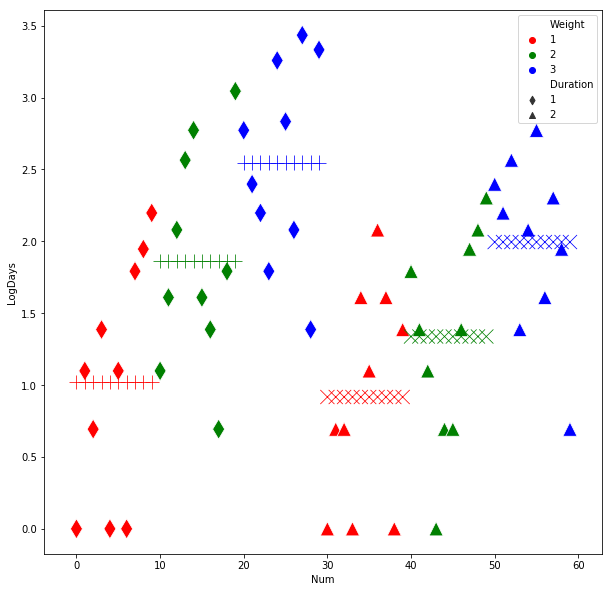

In [146]:
data['Num'] = list(range(len(data)))
fig, ax = plt.subplots(figsize=(10, 10))
sn.scatterplot(
    'Num',
    'LogDays',
    data=data,
    hue='Weight',
    alpha=1,
    style='Duration',
    cmap='rainbow',
    palette=['r', 'g', 'b'],
    ax=ax,
    s=200,
    markers=['d', '^'],
)

sn.scatterplot(
    'Num',
    res2.predict(),
    data=data,
    hue='Weight',
    alpha=1,
    style='Duration',
    cmap='rainbow',
    palette=['r', 'g', 'b'],
    ax=ax,
    s=200,
    markers=['+', 'x'],
    legend=False,
)

Plot Residuals against observation number

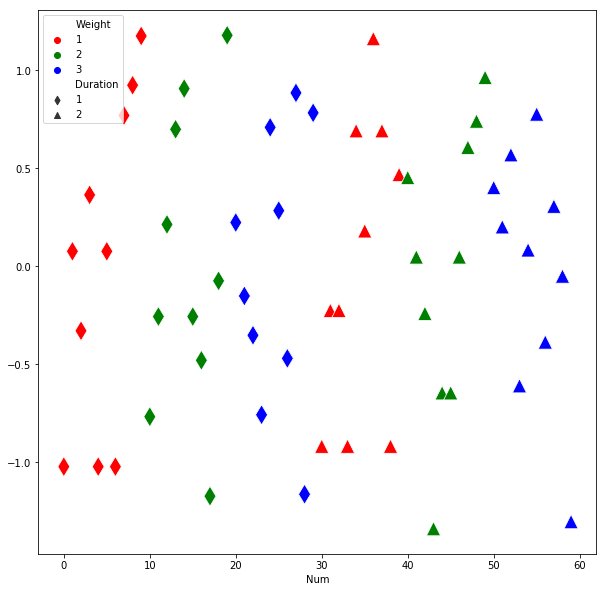

In [147]:
data['Num'] = list(range(len(data)))
fig, ax = plt.subplots(figsize=(10, 10))
sn.scatterplot(
    'Num',
    res2.resid,
    data=data,
    hue='Weight',
    alpha=1,
    style='Duration',
    cmap='rainbow',
    palette=['r', 'g', 'b'],
    ax=ax,
    s=200,
    markers=['d', '^'],
)

Plot Residuals Grouped

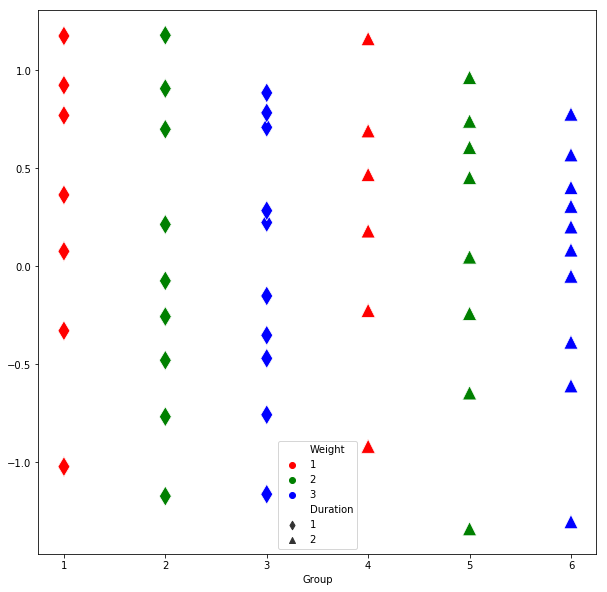

In [148]:
data['Num'] = list(range(len(data)))
fig, ax = plt.subplots(figsize=(10, 10))
sn.scatterplot(
    'Group',
    res2.resid,
    data=data,
    hue='Weight',
    alpha=1,
    style='Duration',
    cmap='rainbow',
    palette=['r', 'g', 'b'],
    ax=ax,
    s=200,
    markers=['d', '^'],
)

------
### Predictions

Supposed we are interested if the group with  Duration level 1, Weight level 3 is significantly different from Duration level 2, Weight level 2.

We compute the predicted value of LogDays for each group

In [149]:
g1 = {'Duration': 1, 'Weight': 3}
g2 = {'Duration': 2, 'Weight': 2}

g1_pred = res2.predict(g1)[0]
g2_pred = res2.predict(g2)[0]

print(g1_pred, g2_pred)

2.548270554114021 1.337719162498504


Get the estimated value of sigma, the standard deviation of the noise

In [150]:
sigma_hat = np.sqrt(res2.mse_resid)
sigma_hat

0.732691612470825

Because we are looking at the difference of means of samples of size n=10, the variance of the estimated difference is as below

$$\text{Var}(\bar{Y}_{13\cdot}) + \text{Var}(\bar{Y}_{22\cdot}) = \frac{2 \sigma^2}{n}.$$

We the upper and lower bounds of our estimate, by using the T distribution.  54 is our degrees of freedom of our residuals (from the RegressionResults.summary() output), and we want the 5% confidence interval

In [151]:
n_obs = 10
lower = stats.t.ppf(0.025, 54) * np.sqrt(
    2 * sigma_hat ** 2 / n_obs
)
upper = stats.t.ppf(0.975, 54) * np.sqrt(
    2 * sigma_hat ** 2 / n_obs
)
lower, upper

(-0.656938094934961, 0.6569380949349609)

Get the difference between the two groups

In [152]:
g_diff = g1_pred - g2_pred
g_diff

1.2105513916155168

Show the upper and lower bounds.  Based upon these values, we would say that at the 5% level, these two groups have a different LogDays value

In [155]:
g_diff + lower, g_diff + upper

(0.5536132966805558, 1.8674894865504776)

The code below shows how to get Confidence Intervals for a Prediction, using the PredictionResults object

In [156]:
gp = res2.get_prediction(
    {'Duration': 1, 'Weight': 1}
)  # PredictionResults Object

gp.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,1.021156,0.231697,0.556631,1.485681,-0.5195,2.561812


--------------------------
## ANOVA

The effect of the interactions can be assessed by a ```anova_lm``` call.  We see that the two categorical variables explain significantly (at the 5% level) more variation that would be predicted by random chance, but not so the interaction between the two variables.

In [157]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    anv = sm.stats.anova_lm(res2)
# end with
anv

,df,sum_sq,mean_sq,F,PR(>F)
"C(Duration, Sum)",1.0,2.339693,2.339693,4.358293,0.041562
"C(Weight, Sum)",2.0,16.971291,8.485645,15.806745,0.000004
"C(Duration, Sum):C(Weight, Sum)",2.0,0.635658,0.317829,0.592040,0.556748
Residual,54.0,28.989198,0.536837,NaN,NaN


We can also compare a simple model (with *no* interactions) with out interaction model.  The difference between the two models would be seen about 50% of the time by random chance

In [158]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    anv = sm.stats.anova_lm(
        ols('LogDays ~ Duration + Weight', data=data).fit(),
        res2,
    )
# end with
anv

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,56.0,29.624856,0.0,NaN,NaN,NaN
1,54.0,28.989198,2.0,0.635658,0.59204,0.556748


-----
## Environment


In [159]:
%watermark -h -iv
%watermark

numpy       1.15.4
pandas      1.0.0
statsmodels 0.9.0
scipy       1.1.0
matplotlib  3.0.2
seaborn     0.9.0
host name: DESKTOP-SODFUN6
2020-03-29T14:58:55+10:00

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
